<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
## Lab 7: 슈퍼바이저 멀티에이전트

## 개요

슈퍼바이저 패턴은 멀티에이전트 시스템에서 가장 기본적인 구조입니다. 하나의 **슈퍼바이저**가 들어온 요청을 분석하고, 적절한 **전문 에이전트**에게 작업을 위임합니다.

```
                    ┌─────────────────┐
                    │   슈퍼바이저    │
                    │   (분류/라우팅)  │
                    └────────┬────────┘
                             │
           ┌─────────────────┼─────────────────┐
           ▼                 ▼                 ▼
    ┌──────────┐      ┌──────────┐      ┌──────────┐
    │  정산    │      │ 웹할인   │      │  오류    │
    │ 에이전트 │      │ 에이전트 │      │ 에이전트 │
    └──────────┘      └──────────┘      └──────────┘
```

이 노트북에서는 **내부 직원 질문 분류 시스템**을 구현합니다:
- 직원이 질문을 입력하면 슈퍼바이저가 카테고리를 분류
- 분류된 카테고리에 따라 전문 에이전트가 응답 생성

<a id='imports'></a>
## 임포트

In [1]:
from IPython.display import Image, display
from typing import Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command
from langchain_openai import ChatOpenAI

<a id='state_definition'></a>
## State 정의

모든 노드가 공유하는 상태를 정의합니다.

In [2]:
class AgentState(TypedDict):
    question: str      # 직원 질문
    category: str      # 분류된 카테고리
    response: str      # 최종 응답

## LLM 설정

In [4]:
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

<a id='supervisor_node'></a>
## 슈퍼바이저 노드

슈퍼바이저는 질문을 분석하고 적절한 전문 에이전트로 라우팅합니다.
- `Command`를 사용하여 다음 노드를 동적으로 결정

In [5]:
def supervisor(state: AgentState) -> Command[Literal["settlement", "web_discount", "error_check"]]:
    """질문을 분류하고 적절한 에이전트로 라우팅"""
    
    classification_prompt = f"""당신은 내부 직원 질문을 분류하는 분류기입니다.
다음 질문을 분석하고, 아래 3가지 카테고리 중 하나로만 답하세요:

- 정산: 정산, 수수료, 결제 대금, 매출 정산 관련 질문
- 웹할인: 웹할인 연동, 할인 적용, 프로모션 연동 관련 질문  
- 오류: 시스템 오류, 버그, 에러, 장애 관련 질문

질문: {state['question']}

카테고리(정산/웹할인/오류 중 하나만):"""
    
    result = llm.invoke(classification_prompt)
    category = result.content.strip()
    
    # 카테고리에 따라 라우팅
    route_map = {
        "정산": "settlement",
        "웹할인": "web_discount",
        "오류": "error_check"
    }
    
    next_node = route_map.get(category, "error_check")  # 기본값: error_check
    
    print(f"[슈퍼바이저] 질문 분류: {category} → {next_node} 에이전트로 전달")
    
    return Command(
        update={"category": category},
        goto=next_node
    )

<a id='specialist_agents'></a>
## 전문 에이전트 노드

각 에이전트는 해당 도메인의 전문가로서 질문에 응답합니다.

In [6]:
def settlement_agent(state: AgentState) -> AgentState:
    """정산 관련 질문 처리"""
    
    prompt = f"""당신은 정산 업무 전문가입니다.
직원의 정산 관련 질문에 친절하고 정확하게 답변해주세요.

질문: {state['question']}

답변:"""
    
    result = llm.invoke(prompt)
    print(f"[정산 에이전트] 응답 생성 완료")
    
    return {"response": result.content}

In [8]:
def web_discount_agent(state: AgentState) -> AgentState:
    """웹할인 연동 관련 질문 처리"""
    
    prompt = f"""당신은 웹할인 연동 업무 전문가입니다.
직원의 웹할인 연동, 프로모션 적용 관련 질문에 친절하고 정확하게 답변해주세요.

질문: {state['question']}

답변:"""
    
    result = llm.invoke(prompt)
    print(f"[웹할인 에이전트] 응답 생성 완료")
    
    return {"response": result.content}

In [9]:
def error_agent(state: AgentState) -> AgentState:
    """오류/장애 관련 질문 처리"""
    
    prompt = f"""당신은 시스템 오류 및 장애 대응 전문가입니다.
직원의 오류, 버그, 장애 관련 질문에 친절하고 정확하게 답변해주세요.

질문: {state['question']}

답변:"""
    
    result = llm.invoke(prompt)
    print(f"[오류 에이전트] 응답 생성 완료")
    
    return {"response": result.content}

<a id='graph_building'></a>
## 그래프 구성

In [10]:
# 그래프 빌더 생성
builder = StateGraph(AgentState)

# 노드 추가
builder.add_node("supervisor", supervisor)
builder.add_node("settlement", settlement_agent)
builder.add_node("web_discount", web_discount_agent)
builder.add_node("error_check", error_agent)

# 엣지 연결
builder.add_edge(START, "supervisor")
# supervisor는 Command로 다음 노드를 결정하므로 별도 엣지 불필요
builder.add_edge("settlement", END)
builder.add_edge("web_discount", END)
builder.add_edge("error_check", END)

# 그래프 컴파일
graph = builder.compile()

## 그래프 시각화

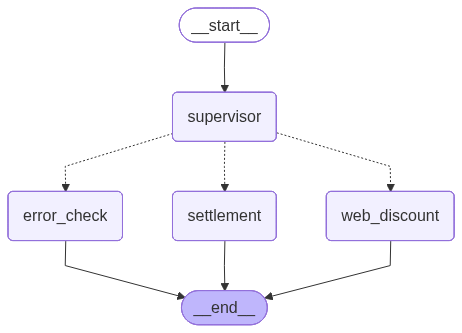

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

<a id='test_execution'></a>
## 테스트 실행

3가지 카테고리별로 테스트해봅니다.

In [12]:
# 테스트 1: 정산 관련 질문
result = graph.invoke({"question": "이번 달 정산 금액이 언제 입금되나요?"})
print(f"\n📋 카테고리: {result['category']}")
print(f"💬 응답:\n{result['response']}")

[슈퍼바이저] 질문 분류: 정산 → settlement 에이전트로 전달
[정산 에이전트] 응답 생성 완료

📋 카테고리: 정산
💬 응답:
좋습니다 — 친절하게 정리해 드릴게요.

일반 원칙
- 정기 급여(월급)는 회사에서 정한 지급일(예: 매월 말일, 25일 등)에 입금됩니다. 지급일이 주말/공휴일이면 회사 규정에 따라 전일 또는 다음 영업일에 입금되는 경우가 많습니다.
- 경비·수당·정산금(출장비, 초과근무수당 등)은 “결재 완료일”과 회사의 회계·지급 주기(매주/격주/매월 등)에 따라 달라집니다. 결재 완료 후 통상 1~5영업일 이내에 지급되는 경우가 많습니다(회사별 차이 큼).
- 프리랜서/외부 정산은 영수증 제출 → 승인 → 회계 지급일 순서로 진행되며 승인 지연이나 서류 미비 시 지급이 늦어집니다.

입금이 지연되는 일반적 원인
- 결재(승인) 미완료 또는 서류 불비
- 계좌번호/입금정보 오류
- 세금·공제 처리 문제
- 회계의 지급 마감일(결재가 지급일 이후에 처리되면 다음 지급주기로 이월)
- 은행 영업일·공휴일

지금 바로 확인할 수 있는 것들
1. 회사의 급여/정산 지급일(사내 캘린더·인사공지 또는 급여정책 확인)  
2. 정산 시스템에서 “결재 완료” 상태인지 확인  
3. 급여명세서·정산 내역(공제 항목 등) 확인  
4. 계좌정보가 정확한지 확인

HR/회계에 문의할 때 쓸 짧은 템플릿
- 제목: [정산입금 확인] 00월 정산금 입금일 문의  
- 내용: 안녕하세요.  (이름/사번)입니다. 00월 분(또는 항목명) 정산금이 현재 결재(또는 승인)되었는지, 언제 입금될 예정인지 확인 부탁드립니다. 계좌는 (은행/계좌번호)입니다. 감사합니다.

정확한 입금일을 알려면 제가 더 알아야 할 정보
- 회사의 정산 종류(월급/출장비/프리랜서 정산 등)  
- 결재(승인) 완료 여부 및 완료일  
- 회사에서 통상 사용하는 지급일(예: 매월 25일, 매월 말 등)

원하시면 위 정보 알려주시면 예상 입금일을 더 정확히 안내해 드리겠습니다.


In [13]:
# 테스트 2: 웹할인 관련 질문
result = graph.invoke({"question": "신규 프로모션을 웹할인에 연동하려면 어떻게 해야 하나요?"})
print(f"\n📋 카테고리: {result['category']}")
print(f"💬 응답:\n{result['response']}")

[슈퍼바이저] 질문 분류: 웹할인 → web_discount 에이전트로 전달
[웹할인 에이전트] 응답 생성 완료

📋 카테고리: 웹할인
💬 응답:
좋습니다. 신규 프로모션을 웹할인(웹/앱 결제 시 적용되는 할인)으로 연동할 때 따라야 할 표준 절차와 체크리스트를 정리해 드립니다. 사용 중인 시스템(자체 할인엔진, 마이크로서비스, 마케팅 오토메이션, 쿠폰관리 등)에 따라 세부 항목이 달라질 수 있으니 필요하면 환경 정보를 알려 주세요 — 그에 맞춘 예시 페이로드나 화면 설정 예를 드리겠습니다.

1) 사전 준비(프로모션 기획 단계)
- 프로모션 목적: 신규 고객 유치, 재구매, 재고 소진 등
- 할인 유형: % 할인, 정액 할인, 배송비 면제, 무료 사은품 등
- 대상 범위: 전체, 특정 카테고리, 특정 SKU, 특정 고객군(회원/비회원/LTV 세그먼트)
- 적용 조건: 최소 구매금액, 상품 개수, 결제 수단 제한 등
- 사용 제한: 1인당 사용 횟수, 총 예산(쿠폰 총 발급 수), 유효기간(시작/종료 시각, 타임존)
- 중복/우선순위 정책: 다른 프로모션과 중복 허용 여부, 우선순위 값
- 반환/환불 처리 규칙: 부분 환불 시 할인 처리 방식

2) 기술적 설계(연동 요건 정의)
- 엔티티 매핑: 프로모션ID, 코드(쿠폰), 명칭, 타입, 유효기간, 조건, 우선순위 등 필드 정의
- 적용시점: 장바구니 단계, 결제 직전, 결제완료 후(리베이트) 중 언제 적용할지
- 호출 방식: 할인엔진 API, 백엔드 룰엔진, 프론트엔드 적용 여부(클라이언트 계산) 등
- 인증/보안: API 키, OAuth, 권한 범위
- 통화/반올림 규칙 및 세금 영향
- 캐시/정합성 이슈: CDN 또는 클라이언트 캐시로 인한 지연 처리

3) 구현(설정 + 개발)
- 프로모션 설정: 마케팅 백오피스 또는 할인엔진에 모든 필드로 생성
  - 필수: promo_id, name, type, value, start_at, end_at, eligible_items, min_amount, max_u

In [14]:
# 테스트 3: 오류 관련 질문
result = graph.invoke({"question": "주문 조회 화면에서 500 에러가 계속 발생합니다."})
print(f"\n📋 카테고리: {result['category']}")
print(f"💬 응답:\n{result['response']}")

[슈퍼바이저] 질문 분류: 오류 → error_check 에이전트로 전달
[오류 에이전트] 응답 생성 완료

📋 카테고리: 오류
💬 응답:
먼저 빠르게 문제를 복구할 수 있도록 우선순위/대응 흐름과 확인할 항목들을 정리해 드립니다. 아래 내용을 따라 확인하고, 확인 결과(로그/에러메시지/재현 방법 등)를 알려주시면 더 구체적으로 원인 분석과 수정 방법을 제안하겠습니다.

1) 즉시 조치 (서비스 영향 최소화, 고객 피해 억제)
- 최근 배포가 있었다면 즉시 롤백을 고려하세요(가장 빠른 복구 수단).
- 트래픽 폭주나 리소스 문제면 스케일 업/스케일 아웃(인스턴스 추가) 또는 큐잉/서킷브레이커로 요청 차단.
- 장애 범위가 크고 원인 불명이라면 서비스 유지보수(메인테넌스) 모드로 전환하고 사용자 안내문 표시.
- 임시우회: 캐시된 주문 데이터를 보여주는 페이지로 리다이렉트하거나 읽기 전용 모드로 전환.

2) 우선 확인할 핵심 정보(제가 바로 분석할 수 있게 보내주시면 빠릅니다)
- 발생 시각(정확한 시간)와 대상 환경(프로덕션/스테이징)
- 재현 방법(어떤 입력/사용자/주문ID로 발생하는지)
- 최근 배포(커밋/태그) 여부 및 변경 내용
- 에러 화면에 나오는 에러ID/Trace ID 또는 전체 스택트레이스(애플리케이션 로그)
- 웹서버/프록시 로그(nginx/apache)에서 해당 요청의 access/error 로그 한 줄
- 애플리케이션 로그(에러 로그 전체), DB 로그(오류/슬로우 쿼리)
- 모니터링 지표: CPU, 메모리, 디스크, 네트워크, DB 커넥션풀 사용률, 응답시간 급증 여부

3) 500 에러의 흔한 원인과 확인 방법
- Unhandled Exception (애플리케이션 레벨)
  확인: 애플리케이션 에러 로그/스택트레이스 확인. Trace/Request ID로 매칭.
- DB 장애 / 타임아웃 / 커넥션 고갈
  확인: DB 에러 로그, 커넥션 풀 사용률(예: HikariCP active connections), pg_stat_activi

## Takeaways

### 슈퍼바이저 패턴의 핵심

**구조:**
- 슈퍼바이저: 요청을 분석하고 적절한 에이전트로 라우팅
- 전문 에이전트: 각 도메인별 전문 처리
- `Command`: 노드 내부에서 동적으로 다음 노드 결정

**언제 사용하면 좋은가:**
- 요청을 카테고리별로 분류해야 할 때
- 각 카테고리마다 다른 처리 로직이 필요할 때
- 전문가 시스템을 구축할 때

### Try Next

- 새로운 카테고리와 전문 에이전트 추가해보기
- 슈퍼바이저가 여러 에이전트를 순차적으로 호출하도록 수정해보기
- `interrupt()`를 추가하여 사람의 승인을 받은 후 응답하도록 변경해보기